## Create examples of network output for figure panels
Created by: Yarden Cohen\
Date: June 2021\
This notebook allows loading specific saved TweetyNet models and examining their outputs.
Cells in this notebook will also hold code to create figure panels showing such network outputs.

In [1]:
# imports
from argparse import ArgumentParser
import configparser  # used to load 'min_segment_dur.ini'

from collections import defaultdict
import json
from pathlib import Path

import joblib
import numpy as np
import pandas as pd
import pyprojroot
import torch
from tqdm import tqdm

from vak import config, io, models, transforms
from vak.datasets.vocal_dataset import VocalDataset
import vak.device
import vak.files
from vak.labeled_timebins import lbl_tb2segments, majority_vote_transform, lbl_tb_segment_inds_list,     remove_short_segments
from vak.core.learncurve import train_dur_csv_paths as _train_dur_csv_paths
from vak.logging import log_or_print
from vak.labeled_timebins import (
    lbl_tb2segments,
    majority_vote_transform,
    lbl_tb_segment_inds_list,
    remove_short_segments
)

In [2]:
def load_network_results(path_to_config=None,
                        spect_scaler_path = None,
                        csv_path=None,
                        labelmap_path=None,
                        checkpoint_path=None,
                        window_size = 370,
                        min_segment_dur = 0.01,
                        num_workers = 12,
                        device='cuda',
                        spect_key='s',
                        timebins_key='t',
                        freq_key = 'f',
                        test_all_files=False):
    '''
    This function loads a model from an EVAL config file or from specified parameters, loads a model, and returns its outputs 
    for a specified test set.
    
    Setting 'test_all_files=True' will create a copy of the list in csv_path where all files are in the test set.
    '''
    if path_to_config:
        # ---- get all the parameters from the config we need
        cfg = config.parse.from_toml_path(path_to_config)
        if cfg.eval: 
            model_config_map = config.models.map_from_path(path_to_config, cfg.eval.models)
            csv_path = cfg.eval.csv_path
            labelmap_path = cfg.eval.labelmap_path
            checkpoint_path = cfg.eval.checkpoint_path
            window_size = cfg.dataloader.window_size
            num_workers = cfg.eval.num_workers
            if spect_scaler_path:
                spect_scaler_path = cfg.eval.spect_scaler_path
        else:
            print('config file must hold parameters in an [EVAL] section')
            return None
    else:
        model_config_map = {'TweetyNet': {'loss': {}, 'metrics': {}, 'network': {}, 'optimizer': {'lr': 0.001}}}
        
    with labelmap_path.open('r') as f:
        labelmap = json.load(f)
    if spect_scaler_path:
        spect_standardizer = joblib.load(spect_scaler_path)
    else:
        spect_standardizer = None
    # prepare evaluation data
    csv_df = pd.read_csv(csv_path)
    if test_all_files==True: # allow creating a new csv 'csv_path_test.csv' where all entries are 'test'
        csv_df['split'] = 'test'
        csv_df.to_csv(csv_path.parent.joinpath(csv_path.stem + '_test.csv'))
        csv_path = csv_path.parent.joinpath(csv_path.stem + '_test.csv')
    csv_df = csv_df[csv_df.split == 'test']
    
    item_transform = transforms.get_defaults('eval',
                                                 spect_standardizer=spect_standardizer,
                                                 window_size=window_size,
                                                 return_padding_mask=True,
                                                 )

    eval_dataset = VocalDataset.from_csv(csv_path=csv_path,
                                         split='test',
                                         labelmap=labelmap,
                                         spect_key=spect_key,
                                         timebins_key=timebins_key,
                                         item_transform=item_transform,
                                         )

    eval_data = torch.utils.data.DataLoader(dataset=eval_dataset,
                                            shuffle=False,
                                            # batch size 1 because each spectrogram reshaped into a batch of windows
                                            batch_size=1,
                                            num_workers=num_workers)
    input_shape = eval_dataset.shape
    # if dataset returns spectrogram reshaped into windows,
    # throw out the window dimension; just want to tell network (channels, height, width) shape
    if len(input_shape) == 4:
        input_shape = input_shape[1:]

    models_map = models.from_model_config_map(
        model_config_map,
        num_classes=len(labelmap),
        input_shape=input_shape
    )
    model_name = 'TweetyNet'
    model = models_map['TweetyNet']
    model.load(checkpoint_path)
    #metrics = model.metrics  # metric name -> callable map we use below in loop
    if device is None:
        device = vak.device.get_default_device()
    pred_dict = model.predict(pred_data=eval_data,
                              device=device)
    
    
    annotation_dfs = [pd.DataFrame(eval_dataset.annots[file_number].seq.as_dict()) for file_number in range(len(csv_df))]
   
    return csv_df, annotation_dfs, pred_dict, labelmap

In [52]:
from matplotlib import gridspec
import matplotlib.pyplot as plt
def create_panels(spect_path,
                  model_output,
                  annotation_df,
                  labelmap,
                  timebin_dur,
                  min_segment_dur = 0.01,
                  spect_key = 's',
                  timebins_key = 't',
                  freq_key = 'f',
                  time_window = [0.01,1.01],
                  freq_window = [500.0,4000.0],
                  figsize = (5,10)):
    spect = vak.files.spect.load(spect_path)[spect_key]
    model_output = np.squeeze(model_output.cpu().numpy())
    model_output = np.transpose(model_output,(0,2,1))
    m_shape = np.shape(model_output)
    model_output = model_output.reshape(m_shape[0]*m_shape[1],m_shape[2])
    t_vec = vak.files.spect.load(spect_path)[timebins_key] #remember to remove [0]
    f_vec = vak.files.spect.load(spect_path)[freq_key]   
    extent = [np.min(t_vec),np.max(t_vec),np.min(f_vec),np.max(f_vec)]
    fig = plt.figure(figsize=figsize)
    fig.suptitle('Example file ' + spect_path)
    gs = gridspec.GridSpec(7,1)
    ax_labels = plt.subplot(gs[0])
    ax_spect = plt.subplot(gs[1:3])
    ax_model = plt.subplot(gs[3:7])
    axs = [ax_labels, ax_spect, ax_model]
    model_output = model_output[:len(t_vec)]
    model_output_argmax = np.argmax(model_output,axis=1)
    # Create a raw prediction
    model_raw_pred_labels, model_raw_pred_onsets, model_raw_pred_offsets = lbl_tb2segments(model_output_argmax,
                                                          labelmap=labelmap,
                                                          t=t_vec,
                                                          min_segment_dur=None,
                                                          majority_vote=False)
    # create a prediction with min syl dur and majority vote 
    segment_inds_list = lbl_tb_segment_inds_list(model_output_argmax, unlabeled_label=labelmap['unlabeled'])
    y_pred_np, segment_inds_list = remove_short_segments(model_output_argmax,
                                                         segment_inds_list,
                                                         timebin_dur=timebin_dur,
                                                         min_segment_dur=min_segment_dur,
                                                         unlabeled_label=labelmap['unlabeled'])
    y_pred_np = majority_vote_transform(y_pred_np,
                                        segment_inds_list)
    #y_pred = to_long_tensor(y_pred_np).to(device)
    model_pro_pred_labels, model_pro_pred_onsets, model_pro_pred_offsets = lbl_tb2segments(y_pred_np,
                                          labelmap=labelmap,
                                          t=t_vec,
                                          min_segment_dur=None,
                                          majority_vote=False)
    
    axs[0].set_xlim(time_window)
    axs[0].set_ylim([0,1])
    axs[1].imshow(np.flipud(spect),aspect='auto',extent=extent,cmap='gray_r',interpolation='nearest')
    axs[1].set_xlim(time_window)
    axs[1].set_ylim(freq_window)
    axs[2].imshow(np.flipud(model_output.T),aspect='auto',extent=[extent[0],extent[1],0.0,np.shape(model_output)[1]],cmap='twilight_shifted',interpolation='nearest')
    axs[2].set_xlim(time_window)
    for i in range(len(annotation_df)):
        t_label = (annotation_df.onsets_s[i]+annotation_df.offsets_s[i])/2
        if ((t_label >= time_window[0]) & (t_label <= time_window[1])):
            axs[0].text(t_label,0.25,str(labelmap[annotation_df.labels[i]]),horizontalalignment='center')
            axs[0].hlines(0.25,annotation_df.onsets_s[i],annotation_df.offsets_s[i],color='red')
            axs[1].vlines(annotation_df.onsets_s[i],freq_window[0],freq_window[1],color='red')
            axs[1].vlines(annotation_df.offsets_s[i],freq_window[0],freq_window[1],color='red')

    # add model predictions here       
    for i in range(len(model_raw_pred_labels)):
        t_label = (model_raw_pred_onsets[i]+model_raw_pred_offsets[i])/2
        if ((t_label >= time_window[0]) & (t_label <= time_window[1])):
            axs[0].text(t_label,0.45,str(labelmap[model_raw_pred_labels[i]]),horizontalalignment='center')
            axs[0].hlines(0.45,model_raw_pred_onsets[i],model_raw_pred_offsets[i],color='green')
            axs[2].vlines(model_raw_pred_onsets[i],labelmap[model_raw_pred_labels[i]],labelmap[model_raw_pred_labels[i]]+1,color='black')
            axs[2].vlines(model_raw_pred_offsets[i],labelmap[model_raw_pred_labels[i]],labelmap[model_raw_pred_labels[i]]+1,color='black')
            axs[2].hlines(labelmap[model_raw_pred_labels[i]],model_raw_pred_onsets[i],model_raw_pred_offsets[i],color='green')
            axs[2].hlines(labelmap[model_raw_pred_labels[i]]+1,model_raw_pred_onsets[i],model_raw_pred_offsets[i],color='green')
            
    # add post-processed model predictions here
    for i in range(len(model_pro_pred_labels)):
        t_label = (model_pro_pred_onsets[i]+model_pro_pred_offsets[i])/2
        if ((t_label >= time_window[0]) & (t_label <= time_window[1])):
            axs[0].text(t_label,0.65,str(labelmap[model_pro_pred_labels[i]]),horizontalalignment='center')
            axs[0].hlines(0.65,model_pro_pred_onsets[i],model_pro_pred_offsets[i],color='blue')
    
    
    
    #timebin_indices = np.where((t_vec >= time_window[0]) & (t_vec <= time_window[1]))[0]
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[0].set_title('orig=red, raw_predict=green, processed_predict=blue')
    axs[1].set_xticks([])
    axs[1].set_ylabel('freq. (Hz)')
    axs[2].set_xlabel('Time(sec)')
    axs[2].set_ylabel('Label')
    return fig,axs


In [5]:
# test
config_file_name = 'D:\\Users\\yarde\\github\\llb16_eval_first_submission_longtrain.toml'

csv_df, annotation_dfs, pred_dict, labelmap = load_network_results(path_to_config = config_file_name)
#model_output = pred_dict[spect_path]
#spect_paths = Path(np.array(csv_df[csv_df.split=='test'].spect_path)[file_number])

Loading checkpoint from:
D:\Users\yarde\Dropbox\TN_results_backup\long_train\llb16\results_210529_114433\TweetyNet\checkpoints\max-val-acc-checkpoint.pt 


batch 244 / 245: 100%|███████████████████████████████████████████████████████████████| 245/245 [00:58<00:00,  4.21it/s]


In [7]:
file_number = 1
spect_key = 's'
timebin_key = 't'
timebin_dur = io.dataframe.validate_and_get_timebin_dur(csv_df)
spect_path = Path(np.array(csv_df[csv_df.split=='test'].spect_path)[file_number])
spect = vak.files.spect.load(spect_path)[spect_key]
t = vak.files.spect.load(spect_path)[timebin_key]
annotation_df = annotation_dfs[file_number]
model_output = pred_dict[str(spect_path)]
print(max(t))

8.904761904761905


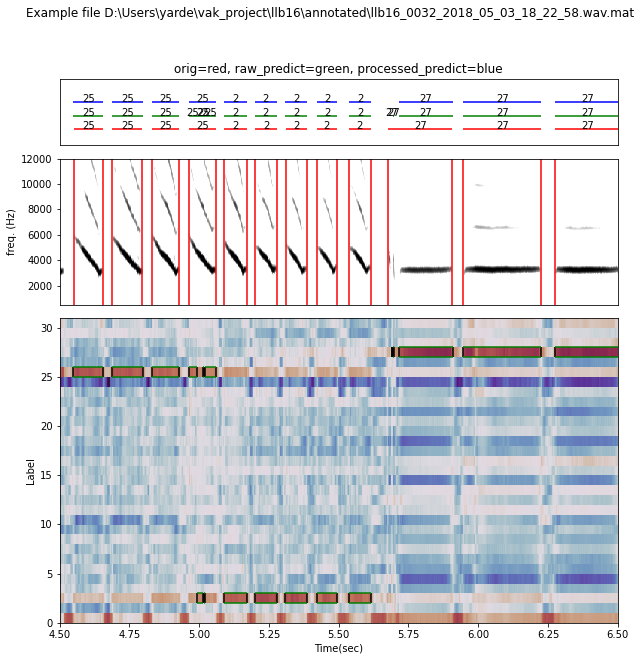

In [53]:
# llb16_file 0032
time_window = [4.5,6.5]
#time_window = [4.75,5.25]
freq_window = [500.0,12000.0]
min_segment_dur = 0.008
fig,axs = create_panels(str(spect_path),
                  model_output,
                  annotation_df,
                  labelmap,
                  timebin_dur,
                  min_segment_dur = min_segment_dur,
                  time_window = time_window,
                  freq_window = freq_window,
                  figsize = (10,10))
plt.show()